In [1]:
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns # For plotting
import matplotlib.pyplot as plt # For showing plots
import scipy.stats as sts
import scikit_posthocs as sp
import statsmodels.stats as stm
from statsmodels.graphics.gofplots import qqplot

## Data formatting

In [2]:
df = pd.read_csv("data/Production_Crops_Livestock_E_All_Data.csv", encoding='latin-1')
#df2 = df.dropna(how = 'any') # removing all missing data 
df2 = df
df2 = df2[df2["Area Code"]<1000] # removing the summerised Areas (Africa as a hole etc.)
df2 = df2.drop(["Area Code", "Area Code (M49)","Item Code (CPC)" ,"Item Code", "Element Code"], axis=1) # removing not used collums
df2 = df2.drop(df2.columns[df2.columns.str.endswith('F')], axis=1) # removing all collums wich say how the data was collectet. Big loss of information!! 
df2 = pd.melt(df2, id_vars=['Area', "Item", "Element", "Unit"], var_name='Year', value_name='Value') # reshaping the df to create a single year collum 
df2['Year'] = df2['Year'].str[1:] # removin the letter of befor the years
df2['Year'] = df2['Year'].astype(int)
df2 = df2.rename(index=str, columns={"Value": "yield_amound"})

dg = pd.read_csv("data/rain.csv", encoding='latin-1')
dg2=dg.drop(['Stop','Indicator','Code','IndicatorCode'], axis=1) 
dg2 = pd.melt(dg2, id_vars=['ï»¿Area'], var_name='Year', value_name='Value') # reshaping the df to create a single year collum 	
dg2=dg2.dropna()
dg2 = dg2.rename(index=str, columns={"Value": "rain"})
dg2 = dg2.rename(index=str, columns={"ï»¿Area": "Area"})
dg2['Year']=dg2['Year'].astype('int')

dr = pd.read_csv("data/FAOSTAT_data_en_4-18-2023.csv", encoding='latin-1')
dr2 = dr
#dr2 = dr.dropna(how = 'any') # removing all missing data 
dr2 = dr2.drop(["ï»¿Domain Code", "Area Code (M49)", "Item Code", "Element Code", "Year Code", "Flag", "Flag Description"], axis=1) # removing not used collums
dr2 = dr2.rename(index=str, columns={"Value": "pesticide_amound"})

di = pd.read_csv("data/temp.csv", encoding='latin-1')
#di2 = di.dropna(how = 'any') # removing all missing data 
di2 = di 
di2 = di2.rename(index=str, columns={"year": "Year"}) # renaming collums 
di2 = di2.rename(index=str, columns={"country": "Area"}) #renaming collums 
di2 = di2.drop_duplicates(subset=['Area', "Year"], keep='last')

merged = pd.merge(df2, dr2, on= ["Area", "Year"], how= "outer" )
merged = pd.merge(di2, merged, on= ["Area", "Year"], how= "outer")
merged = pd.merge(dg2, merged, on= ["Area", "Year"], how= "outer")

merged=merged[(merged['Unit_x']=='tonnes')]

merged

,Area,Year,rain,avg_temp,Item_x,Element_x,Unit_x,yield_amound,Domain,Element_y,Item_y,Unit_y,pesticide_amound
2,Afghanistan,1961,327.0,14.23,"Almonds, in shell",Production,tonnes,NaN,NaN,NaN,NaN,NaN,NaN
5,Afghanistan,1961,327.0,14.23,"Anise, badian, coriander, cumin, caraway, fenn...",Production,tonnes,NaN,NaN,NaN,NaN,NaN,NaN
8,Afghanistan,1961,327.0,14.23,Apples,Production,tonnes,15100.00,NaN,NaN,NaN,NaN,NaN
11,Afghanistan,1961,327.0,14.23,Apricots,Production,tonnes,32000.00,NaN,NaN,NaN,NaN,NaN
15,Afghanistan,1961,327.0,14.23,Barley,Production,tonnes,378000.00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23217989,Zimbabwe,2021,NaN,NaN,Sheep and Goat Meat,Production,tonnes,30592.00,NaN,NaN,NaN,NaN,NaN
23217992,Zimbabwe,2021,NaN,NaN,"Skim Milk & Buttermilk, Dry",Production,tonnes,NaN,NaN,NaN,NaN,NaN,NaN
23217995,Zimbabwe,2021,NaN,NaN,Sugar Crops Primary,Production,tonnes,3450000.00,NaN,NaN,NaN,NaN,NaN
23217998,Zimbabwe,2021,NaN,NaN,"Treenuts, Total",Production,tonnes,7025.62,NaN,NaN,NaN,NaN,NaN


In [3]:
# Addition of a collone region


df_Europe = merged[(merged['Area']=='Albania')| (merged['Area']=='Austria')| (merged['Area']=='Bulgaria')| (merged['Area']=='Switzerland')| (merged['Area']=='Germany')| (merged['Area']=='Denmark')| (merged['Area']=='Hungary')| (merged['Area']=='Spain')| (merged['Area']=='Finland')| (merged['Area']=='France')| (merged['Area']=='Greece')| (merged['Area']=='Ireland')| (merged['Area']=='Italy')| (merged['Area']=='Netherlands')| (merged['Area']=='Norway')| (merged['Area']=='Portugal')| (merged['Area']=='Sweden')| (merged['Area']=='Romania')]
df_Africa= merged[(merged['Area']=='Angola')| (merged['Area']=='Burundi')| (merged['Area']=='Burkina Faso')| (merged['Area']=='Botswana')| (merged['Area']=='Central African Republic')| (merged['Area']=='Cameroon')| (merged['Area']=='Congo')| (merged['Area']=='Algeria')| (merged['Area']=='Egypt')| (merged['Area']=='Ghana')| (merged['Area']=='Guinea')| (merged['Area']=='Kenya')| (merged['Area']== 'Libya')| (merged['Area']=='Lesotho')| (merged['Area']=='Morocco')| (merged['Area']=='Madagascar')| (merged['Area']=='Mali')| (merged['Area']=='Mozambique')| (merged['Area']=='Mauritania')| (merged['Area']=='Mauritius')| (merged['Area']=='Malawi')| (merged['Area']=='Namibia')| (merged['Area']=='Niger')| (merged['Area']=='Rwanda')| (merged['Area']=='Senegal')| (merged['Area']=='Tunisia')| (merged['Area']=='Uganda')| (merged['Area']=='South Africa')| (merged['Area']=='Zambia')| (merged['Area']=='Zimbabwe')]
df_America =merged[(merged['Area']=='Argentina')| (merged['Area']=='Bahamas')| (merged['Area']=='Brazil')| (merged['Area']=='Canada')| (merged['Area']=='Chile')| (merged['Area']=='Colombia')| (merged['Area']=='Dominican Republic')| (merged['Area']=='Ecuador')| (merged['Area']=='Guatemala')| (merged['Area']=='Guyana')| (merged['Area']=='Honduras')| (merged['Area']=='Haiti')| (merged['Area']=='Jamaica')| (merged['Area']=='Mexico')| (merged['Area']=='Nicaragua')| (merged['Area']=='Peru')| (merged['Area']=='El Salvador')| (merged['Area']=='Uruguay' )]
df_Asie = merged[(merged['Area']=='Bangladesh')| (merged['Area']=='Bahrain')| (merged['Area']=='China')| (merged['Area']=='Indonesia')| (merged['Area']== 'India')| (merged['Area']=='Iraq')| (merged['Area']=='Japan')| (merged['Area']=='Lebanon')| (merged['Area']=='Sri Lanka')| (merged['Area']=='Mongolia')| (merged['Area']=='Malaysia')| (merged['Area']=='Nepal')| (merged['Area']=='Pakistan')| (merged['Area']== 'Philippines')| (merged['Area']=='Qatar')| (merged['Area']=='Saudi Arabia')| (merged['Area']=='Suriname')| (merged['Area']=='Thailand')]
df_Oceanie= merged[(merged['Area']=='Australia')| (merged['Area']=='New Zealand')| (merged['Area']=='Papua New Guinea')]

df_Europe["region"]="Europe"
df_Africa["region"]="Africa"
df_Asie["region"]="Asia"
df_America["region"]="America"
df_Oceanie["region"]="Oceania"

region = df_Europe.append(df_Africa, ignore_index=True)
region = region.append(df_Asie, ignore_index=True)
region = region.append(df_America, ignore_index=True)
region = region.append(df_Oceanie, ignore_index=True)



<ipython-input-3-3fdec066a87a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Europe["region"]="Europe"
<ipython-input-3-3fdec066a87a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Africa["region"]="Africa"
<ipython-input-3-3fdec066a87a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [5]:
region

,Area,Year,rain,avg_temp,Item_x,Element_x,Unit_x,yield_amound,Domain,Element_y,Item_y,Unit_y,pesticide_amound,region
0,Albania,1990,1485.0,16.37,Apples,Production,tonnes,13100.00,Pesticides Use,Agricultural Use,Pesticides (total),tonnes,121.0,Europe
1,Albania,1990,1485.0,16.37,Apples,Production,tonnes,13100.00,Pesticides Use,Agricultural Use,Insecticides,tonnes,70.0,Europe
2,Albania,1990,1485.0,16.37,Apples,Production,tonnes,13100.00,Pesticides Use,Agricultural Use,Herbicides,tonnes,5.0,Europe
3,Albania,1990,1485.0,16.37,Apples,Production,tonnes,13100.00,Pesticides Use,Agricultural Use,Fungicides and Bactericides,tonnes,44.0,Europe
4,Albania,1990,1485.0,16.37,Apples,Production,tonnes,13100.00,Pesticides Use,Agricultural Use,Fungicides â Seed treatments,tonnes,0.0,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5918074,Papua New Guinea,2013,3142.0,25.44,Vegetables Primary,Production,tonnes,537659.95,Pesticides Use,Agricultural Use,Mineral Oils,tonnes,0.0,Oceania
5918075,Papua New Guinea,2013,3142.0,25.44,Vegetables Primary,Production,tonnes,537659.95,Pesticides Use,Agricultural Use,Herbicides,tonnes,104.0,Oceania
5918076,Papua New Guinea,2013,3142.0,25.44,Vegetables Primary,Production,tonnes,537659.95,Pesticides Use,Agricultural Use,Fungicides and Bactericides,tonnes,0.0,Oceania
5918077,Papua New Guinea,2013,3142.0,25.44,Vegetables Primary,Production,tonnes,537659.95,Pesticides Use,Agricultural Use,Plant Growth Regulators,tonnes,0.0,Oceania


### Short statistics and data visualisation  

Text(0.5, 1.0, 'region')

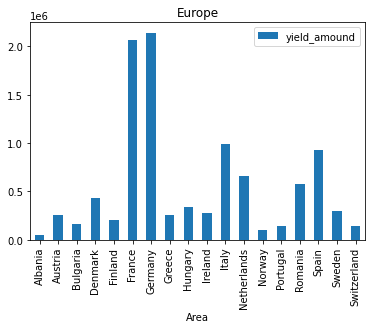

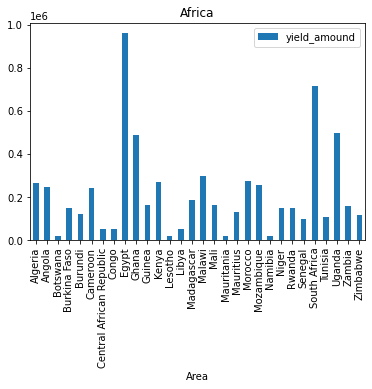

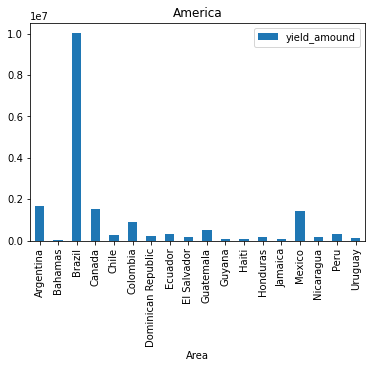

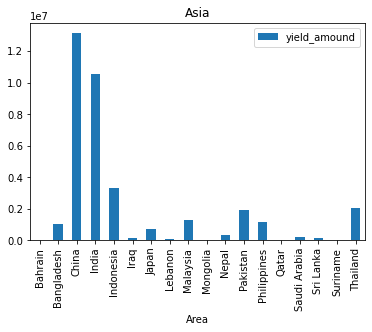

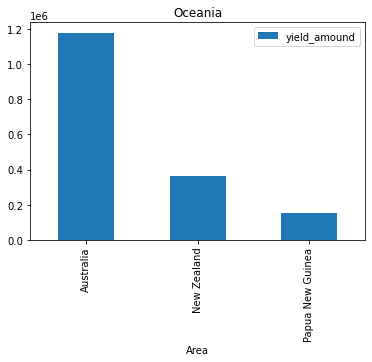

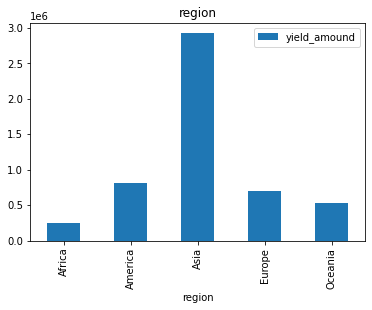

In [4]:

A=df_Europe.groupby("Area")[["yield_amound"]].mean()
A.plot(kind='bar').set_title("Europe")

B=df_Africa.groupby("Area")[["yield_amound"]].mean()
B.plot(kind='bar').set_title("Africa")

C=df_America.groupby("Area")[["yield_amound"]].mean()
C.plot(kind='bar').set_title("America")

D=df_Asie.groupby("Area")[["yield_amound"]].mean()
D.plot(kind='bar').set_title("Asia")


E=df_Oceanie.groupby("Area")[["yield_amound"]].mean()
E.plot(kind='bar').set_title("Oceania")

F=region.groupby('region')[['yield_amound']].mean()
F.plot(kind='bar').set_title("region")



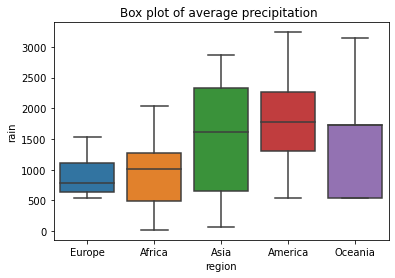

In [5]:
sns.boxplot(x="region", y="rain", data=region).set_title("Box plot of average precipitation ")
plt.show()

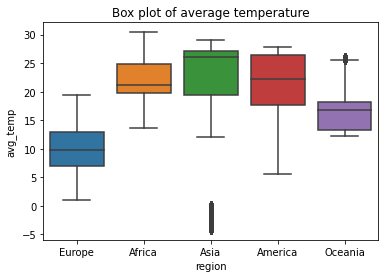

In [6]:
sns.boxplot(x="region", y="avg_temp", data=region).set_title("Box plot of average temperature")
plt.show()

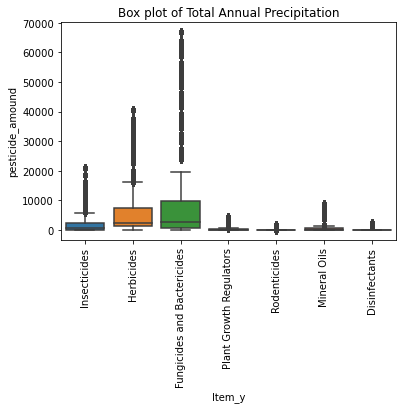

In [5]:
data=region[(region['Item_y']=='Insecticides')|(region['Item_y']=='Herbicides')|(region['Item_y']=='Fungicides and Bactericides')|(region['Item_y']=='Rodenticides')|(region['Item_y']=='Plant Growth Regulators')|(region['Item_y']=='Mineral Oils')|(region['Item_y']=='Disinfectants')]
data=data[(data['region']=='Europe')]
#data_cereal=data_cereal[(data['Item_x']=='Cereals, primary')]
sns.boxplot(x="Item_y", y="pesticide_amound", data=data).set_title("Box plot of Total Annual Precipitation")
plt.xticks(rotation=90)
plt.show()

In [10]:
New=pd.pivot_table(
    data=merged,
    index='Area', # lines will be indexed by 'Hold'
    columns='Item_x', # Columns defined by the 'Fruit' categories
    values='yield_amound', # The values in the resulting table
    aggfunc='mean' # sums the production by 'Hold'
)
New = New.fillna(0)

In [11]:
New

Item_x,"Abaca, manila hemp, raw","Agave fibres, raw, n.e.c.","Almonds, in shell","Anise, badian, coriander, cumin, caraway, fennel and juniper berries, raw",Apples,Apricots,Areca nuts,Artichokes,Asparagus,Avocados,...,Wheat,"Whey, condensed","Whey, dry",Whole milk powder,"Whole milk, condensed","Whole milk, evaporated",Wine,Yams,Yautia,Yoghurt
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.0,0.0,19884.132340,8554.175556,50317.484098,54693.596066,0.0,0.000000,0.000000,0.000000,...,2.874651e+06,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000
Albania,0.0,0.0,0.000000,0.000000,34879.538886,2207.019429,0.0,0.000000,0.000000,0.000000,...,3.338193e+05,0.0,0.000000,0.000000,0.000000,0.000000,14327.075177,0.000000,0.0,0.00000
Algeria,0.0,0.0,36638.155000,0.000000,216676.279815,128508.200185,0.0,45212.387963,0.000000,0.000000,...,2.110284e+06,0.0,0.000000,0.000000,0.000000,0.000000,119339.367094,0.000000,0.0,0.00000
Angola,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,4.652388e+03,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000
Antigua and Barbuda,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,98.930342,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Viet Nam,0.0,0.0,0.000000,3775.081759,0.000000,0.000000,0.0,0.000000,0.000000,91867.000000,...,0.000000e+00,0.0,0.000000,111211.428571,6964.722419,0.000000,7858.562727,0.000000,0.0,2603.57000
Yemen,0.0,0.0,3358.926256,0.000000,10674.027957,3866.870337,0.0,0.000000,0.000000,0.000000,...,1.497788e+05,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000
Yugoslav SFR,0.0,0.0,3908.476190,1261.428571,439895.650794,31407.841270,0.0,0.000000,0.000000,0.000000,...,5.724711e+06,0.0,2406.487937,16863.190476,0.571429,217.181818,587994.619048,0.000000,0.0,10.25641


## Correlation 

c:\Users\aliss\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\aliss\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\aliss\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\aliss\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\aliss\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\aliss\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

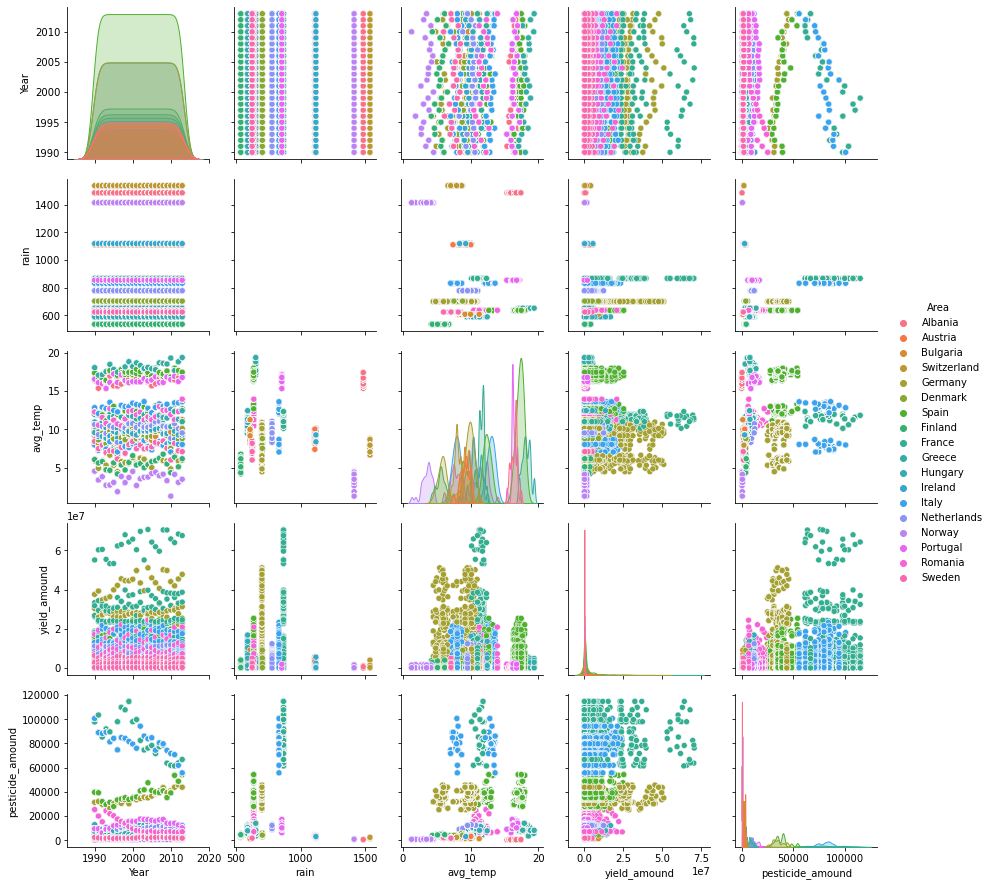

In [11]:
sns.pairplot(df_Europe, hue='Area');

#### correlation pesticide (total)/yield 

In [10]:
from scipy.stats import multivariate_normal
from scipy import stats 

In [7]:
data= merged[merged["Item_y"]== "Pesticides (total)"]

In [8]:
data_1=data[data["Item_x"]=="Rice"]
data_1=data_1[data_1["Area"]=="China"]

data_2=data[data["Item_x"]=="Cereals, primary"]
data_2=data_2[data_2["Area"]=="Portugal"]

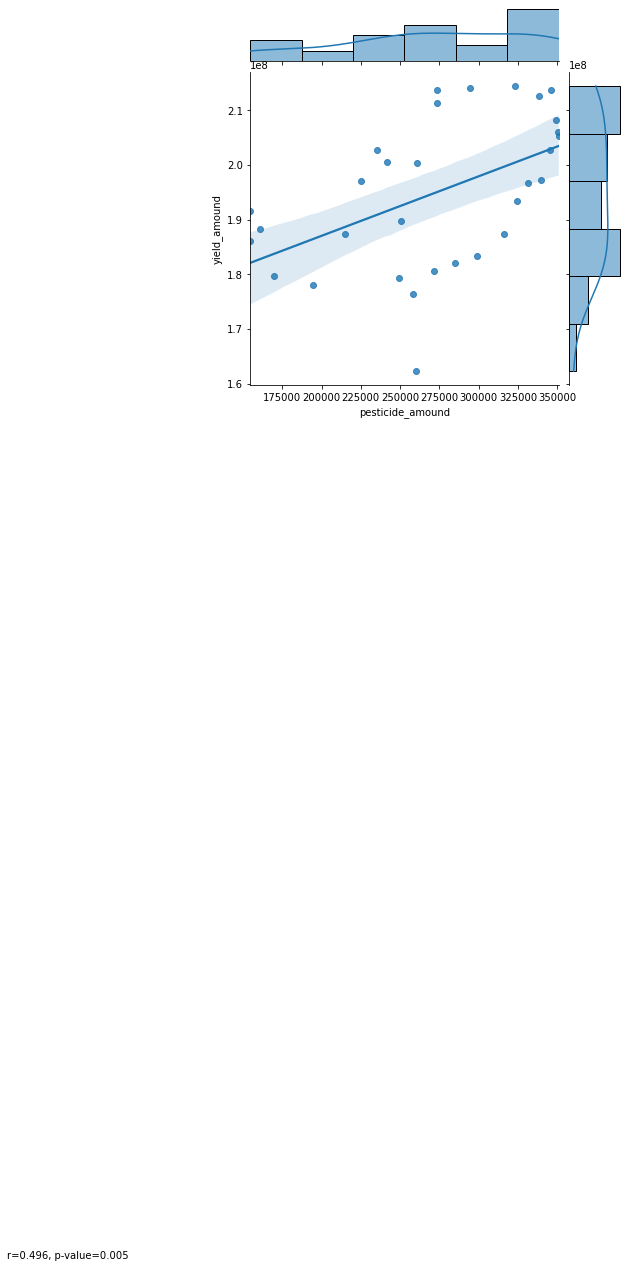

In [11]:
# Composed plots with scatterplot and histograms
stat, p = stats.pearsonr(x=data_1["pesticide_amound"], y=data_1["yield_amound"])

g=sns.jointplot(x=data_1["pesticide_amound"], y=data_1["yield_amound"], kind='reg', data=data_1)
g.ax_joint.text(x=4.5, y=8, s=('r=%.3f, p-value=%.3f' % (stat, p))); # to show results from the correlation test

In [12]:
# test Pearson's correlation between sepal length and petal length
stat, p = stats.pearsonr(x=data_1["pesticide_amound"], y=data_1["yield_amound"])
print('r=%.3f, p-value=%.3f' % (stat, p))

r=0.496, p-value=0.005


#### Correlation rain/yield 

In [21]:
data= merged[merged["Item_y"]== "Pesticides (total)"]
C=data.groupby('Area')[["yield_amound","rain"]].mean()
C['yield']=np.log10(C['yield_amound'])
C=C.dropna()

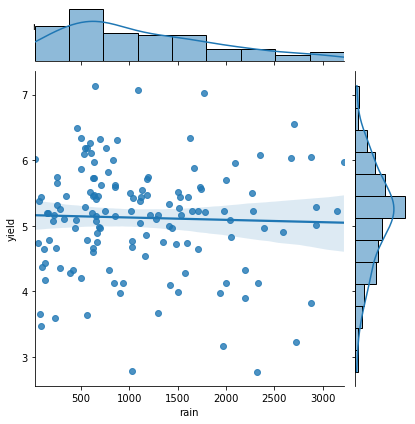

In [22]:
# Composed plots with scatterplot and histograms
stat, p = stats.pearsonr(x=C["rain"], y=C["yield"])

g=sns.jointplot(x=C["rain"], y=C["yield"], kind='reg', data=C)
g.ax_joint.text(x=4.5, y=8, s=('r=%.3f, p-value=%.3f' % (stat, p))); # to show results from the correlation test

In [23]:
# test Pearson's correlation between sepal length and petal length
stat, p = stats.pearsonr(x=C["rain"], y=C["yield"])
print('r=%.3f, p-value=%.3f' % (stat, p))

r=-0.034, p-value=0.686


#### Correlation temperature/yield

In [26]:
data= merged[merged["Item_y"]== "Pesticides (total)"]
D=data.groupby('Area')[["yield_amound","avg_temp"]].mean()
D['yield']=np.log10(C['yield_amound'])
D=D.dropna()

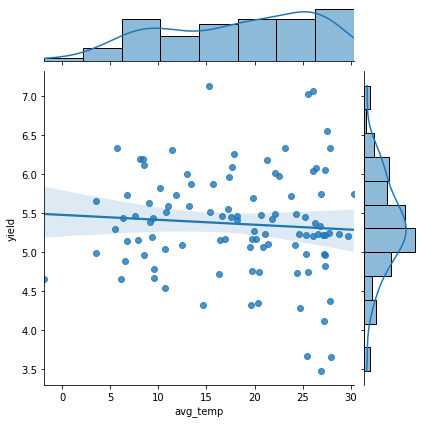

In [33]:
# Composed plots with scatterplot and histograms
stat, p = stats.pearsonr(x=D["avg_temp"], y=D["yield"])

g=sns.jointplot(x=D["avg_temp"], y=D["yield"], kind='reg', data=D)
g.ax_joint.text(x=4.5, y=8, s=('r=%.3f, p-value=%.3f' % (stat, p)));

In [34]:
# test Pearson's correlation between sepal length and petal length
stat, p = stats.pearsonr(x=D["avg_temp"], y=D["yield"])
print('r=%.3f, p-value=%.3f' % (stat, p))

r=-0.073, p-value=0.464


In [43]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

data= merged[merged["Item_y"]== "Pesticides (total)"]
data=data.dropna()
y=data["yield_amound"]
x=data[["avg_temp", "rain","pesticide_amound"]]

x = sm.add_constant(x) # adding a constant (Intercept)

model = sm.OLS(y, x).fit()
predictions = model.predict(x) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:           yield_amound   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     3339.
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        09:38:22   Log-Likelihood:            -5.0558e+06
No. Observations:              287762   AIC:                         1.011e+07
Df Residuals:                  287758   BIC:                         1.011e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -4.168e+05   5.28e+04  

## Evolution with time 

In [35]:
merged_cereal = merged[merged["Item_x"]== "Cereals, primary"]

[(0.0, 3840390256.5895)]

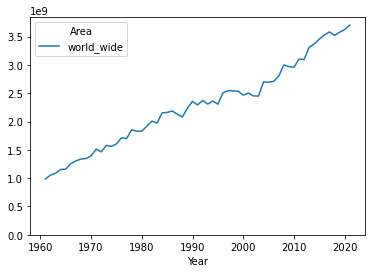

In [36]:
merged_cereal_wide = merged_cereal.drop_duplicates(subset=['Area', 'Year'], keep='last')
merged_cereal_wide = merged_cereal_wide.pivot(index= "Year",columns= "Area",values= "yield_amound")
merged_cereal_wide['world_wide'] = merged_cereal_wide[list(merged_cereal_wide.columns)].sum(axis=1)
p1 = sns.lineplot(data=merged_cereal_wide[["world_wide"]])
p1.set(ylim=(0))

[(0.0, 6.0413722500418405)]

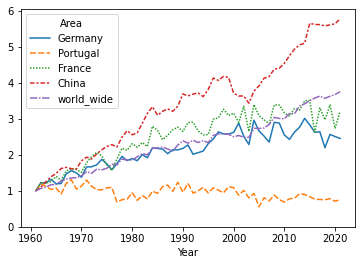

In [37]:
merged_cereal_wide_div = merged_cereal_wide.div(merged_cereal_wide.iloc[0]) 
p1 = sns.lineplot(data = merged_cereal_wide_div[["Germany", "Portugal", "France", "China", "world_wide"]])
p1.set(ylim=(0))

In [38]:
df_pesticide=merged[merged['Item_y']=='Pesticides (total)']
df_pesticide=df_pesticide[df_pesticide['Item_x']=='Cereals, primary']

[(0.0, 3094509.5325000007)]

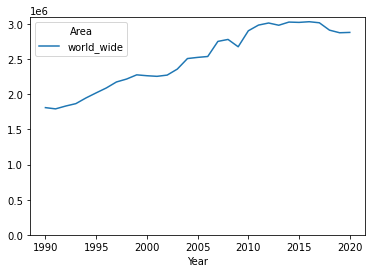

In [39]:
df_pesticide = df_pesticide.drop_duplicates(subset=['Area', 'Year'], keep='last')
df_pesticide = df_pesticide.pivot(index= "Year",columns= "Area",values= "pesticide_amound")
df_pesticide['world_wide'] = df_pesticide[list(df_pesticide.columns)].sum(axis=1)
p1 = sns.lineplot(data=df_pesticide[["world_wide"]])
p1.set(ylim=(0))

[(0.0, 2.3561685900009968)]

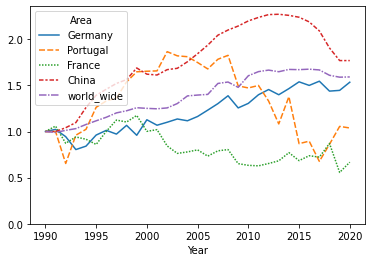

In [40]:
df_pesticide_div = df_pesticide.div(df_pesticide.iloc[0]) 
p2 = sns.lineplot(data = df_pesticide_div[["Germany", "Portugal", "France", "China", "world_wide"]])
p2.set(ylim=(0))

### PCA

I think that to start with you have to analyse the different components and for that you can use a PCA

In [ ]:
print('Item_x',len(merged['Item_x'].unique()),merged['Item_x'].unique())

In [39]:

data=merged[(merged['Item_x']=='Rice')| (merged['Item_x']=='Wheat')| (merged['Item_x']=='Maize')|(merged['Item_x']=='Fruit Primary')|(merged['Item_x']=='Cattle and Buffaloes')|(merged['Item_x']=='Sugar Crops Primary')]
data=data[(data["Area"]=="Germany")| (data["Area"]=="Portugal")| (data["Area"]== "France")| (data["Area"]== "China")]
data=data[data['Item_y']=='Pesticides (total)']
df = data[[ "avg_temp", "yield_amound","pesticide_amound","rain"]]
df_2= data[[ "Area", "Item_x", "avg_temp", "yield_amound","pesticide_amound","rain"]]
df

,avg_temp,yield_amound,pesticide_amound,rain
95376,8.66,1.916147e+08,154560.89,645.0
95904,8.66,9.823194e+07,154560.89,645.0
96025,8.66,3.492618e+07,154560.89,645.0
96212,8.66,7.797558e+07,154560.89,645.0
98511,6.86,1.916147e+08,154560.89,645.0
...,...,...,...,...
15593425,11.01,8.403798e+06,66676.69,867.0
15594034,11.01,3.363054e+07,66676.69,867.0
15857328,16.77,1.801550e+05,10126.80,854.0
15858004,16.77,9.201400e+04,10126.80,854.0


In [40]:
def binning(col, cut_points, labels=None):
    # Définir les valeurs min et max:
    minval = col.min()
    maxval = col.max()

    # Créer une liste en ajoutant min et max à cut_points
    break_points = [minval] + cut_points + [maxval]

    # Si aucun label, on utilise par défaut les labels 0 ... (n-1)
    if not labels:
        labels = range(len(cut_points)+1)

    # Regroupement en utilisant la fonction cut de Pandas
    colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
    return colBin

cut_points = [5000000,75000000,100000000,120000000,170000000,200000000]
labels = ["1","2","3","4","5","6","7"] # 1= low yield 5= very high yield 
df_2["classe"] = binning(df_2["yield_amound"], cut_points, labels)
print(pd.value_counts(df_2["classe"], sort=False))

1    165
2    423
3    884
4    544
5    578
6    748
7    306
Name: classe, dtype: int64


<ipython-input-40-5d324f0b75e4>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["classe"] = binning(df_2["yield_amound"], cut_points, labels)


In [41]:
object_columns = df_2.select_dtypes(include='object').columns
data_1 = pd.get_dummies(data= df_2, columns=object_columns)

In [34]:
data_1

,avg_temp,yield_amound,pesticide_amound,classe,Area_China,Area_France,Area_Germany,Area_Portugal,Item_x_Fruit Primary,Item_x_Rice,Item_x_Sugar Crops Primary,Item_x_Wheat
95376,8.66,1.916147e+08,154560.89,6,1,0,0,0,0,1,0,0
95904,8.66,9.823194e+07,154560.89,3,1,0,0,0,0,0,0,1
96025,8.66,3.492618e+07,154560.89,2,1,0,0,0,1,0,0,0
96212,8.66,7.797558e+07,154560.89,3,1,0,0,0,0,0,1,0
98511,6.86,1.916147e+08,154560.89,6,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
15593425,11.01,8.403798e+06,66676.69,2,0,1,0,0,1,0,0,0
15594034,11.01,3.363054e+07,66676.69,2,0,1,0,0,0,0,1,0
15857328,16.77,1.801550e+05,10126.80,1,0,0,0,1,0,1,0,0
15858004,16.77,9.201400e+04,10126.80,1,0,0,0,1,0,0,0,1


In [42]:
df = data_1[[ "avg_temp","pesticide_amound","rain","Area_China","Area_France","Area_Germany","Area_Portugal","Item_x_Fruit Primary","Item_x_Rice","Item_x_Sugar Crops Primary","Item_x_Wheat"]]
df_2= data_1[[ "avg_temp","pesticide_amound","rain","Area_China","Area_France","Area_Germany","Area_Portugal","Item_x_Fruit Primary","Item_x_Rice","Item_x_Sugar Crops Primary","Item_x_Wheat","classe"]]

In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
yield_scaled = StandardScaler().fit_transform(df)
# As a result, we obtained a two-dimensional NumPy array. We can convert it to a pandas DataFrame for a better display.
df_scaled = pd.DataFrame(data=yield_scaled, 
                                columns=df.columns)
df_scaled.head()

,avg_temp,pesticide_amound,rain,Area_China,Area_France,Area_Germany,Area_Portugal,Item_x_Fruit Primary,Item_x_Rice,Item_x_Sugar Crops Primary,Item_x_Wheat
0,-0.895405,-0.926853,-0.28431,0.342997,-0.164399,-0.250873,-0.141895,-0.587480,1.795055,-0.577350,-0.587480
1,-0.895405,-0.926853,-0.28431,0.342997,-0.164399,-0.250873,-0.141895,-0.587480,-0.557086,-0.577350,1.702186
2,-0.895405,-0.926853,-0.28431,0.342997,-0.164399,-0.250873,-0.141895,1.702186,-0.557086,-0.577350,-0.587480
3,-0.895405,-0.926853,-0.28431,0.342997,-0.164399,-0.250873,-0.141895,-0.587480,-0.557086,1.732051,-0.587480
4,-1.248076,-0.926853,-0.28431,0.342997,-0.164399,-0.250873,-0.141895,-0.587480,1.795055,-0.577350,-0.587480


In [44]:
pca = PCA(n_components=2)
PC = pca.fit_transform(df_scaled)

In [45]:
pca_yield = pd.DataFrame(data = PC, 
                            columns = ['PC1', 'PC2'])
pca_yield.head(6)

,PC1,PC2
0,-0.119026,0.777432
1,0.102480,-0.573274
2,0.102480,-0.573274
3,-0.006079,-1.210063
4,-0.081065,0.663233
5,0.140441,-0.687473


Text(0, 0.5, 'PC2')

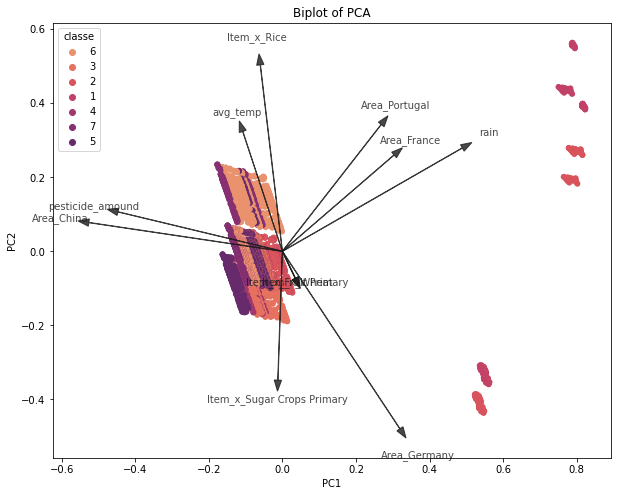

In [50]:
PC1 = pca_yield['PC1']/(pca_yield['PC1'].max() - pca_yield['PC1'].min())
PC2 = pca_yield['PC2']/(pca_yield['PC2'].max() - pca_yield['PC2'].min())

plt.figure(figsize=(10, 8))
plt.title('Biplot of PCA')
sns.scatterplot(x=PC1,
              y=PC2,
              hue = df_2['classe'].tolist(),
              linewidth=0,
              palette="flare",
              legend="full",
              )

n = np.transpose(pca.components_).shape[0] # number of dimensions (2)
for i in range(n):
        plt.arrow(0, 0, np.transpose(pca.components_)[i,0], 
                  np.transpose(pca.components_)[i,1], 
                  color = (0.1, 0.1, 0.1, 0.8),
                  head_width=0.02) # plot arrows for each variable
        plt.text(np.transpose(pca.components_)[i,0]* 1.15, 
                 np.transpose(pca.components_)[i,1] * 1.15, 
                 list(df.columns)[i], 
                 color = (0.1, 0.1, 0.1, 0.8), 
                 ha = 'center', 
                 va = 'center') # variable labels for each arrow
plt.legend(title='classe')
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))

regression

In [ ]:
# import formula api as alias smf 
import statsmodels.formula.api as smf
# Run logistic regression
# To use a formula with statsmodels.formula.api (smf) we need to create a species name with no spaces (replace by underscores)
log_reg = smf.logit("yield_amound ~ avg_temp + rain + pesticide_amound", data=merged).fit()
log_reg.summary()

cliamtic condition 

In [12]:
data

,Area,Year,rain,avg_temp,Item_x,Element_x,Unit_x,yield_amound,Domain,Element_y,Item_y,Unit_y,pesticide_amound
1045,Angola,1990,1010.0,24.12,Rice,Production,tonnes,3000.0,Pesticides Use,Agricultural Use,Pesticides (total),tonnes,64.0
1046,Angola,1990,1010.0,24.12,Rice,Production,tonnes,3000.0,Pesticides Use,Agricultural Use,Insecticides,tonnes,56.0
1047,Angola,1990,1010.0,24.12,Rice,Production,tonnes,3000.0,Pesticides Use,Agricultural Use,Insecticides â Chlorinated Hydrocarbons,tonnes,30.0
1048,Angola,1990,1010.0,24.12,Rice,Production,tonnes,3000.0,Pesticides Use,Agricultural Use,Insecticides â Organo-phosphates,tonnes,17.0
1049,Angola,1990,1010.0,24.12,Rice,Production,tonnes,3000.0,Pesticides Use,Agricultural Use,Insecticides â Carbamates,tonnes,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15909141,Zimbabwe,2013,657.0,19.76,Sugar Crops Primary,Production,tonnes,3960000.0,Pesticides Use,Agricultural Use,Insecticides â Seed Treatments,tonnes,0.0
15909142,Zimbabwe,2013,657.0,19.76,Sugar Crops Primary,Production,tonnes,3960000.0,Pesticides Use,Agricultural Use,Plant Growth Regulators,tonnes,177.7
15909143,Zimbabwe,2013,657.0,19.76,Sugar Crops Primary,Production,tonnes,3960000.0,Pesticides Use,Agricultural Use,Rodenticides,tonnes,0.0
15909144,Zimbabwe,2013,657.0,19.76,Sugar Crops Primary,Production,tonnes,3960000.0,Pesticides Use,Agricultural Use,Rodenticides â Anti-coagulants,tonnes,0.0


In [71]:
#creates yield classes 
# Binning:
def binning(col, cut_points, labels=None):
    # Définir les valeurs min et max:
    minval = col.min()
    maxval = col.max()

    # Créer une liste en ajoutant min et max à cut_points
    break_points = [minval] + cut_points + [maxval]

    # Si aucun label, on utilise par défaut les labels 0 ... (n-1)
    if not labels:
        labels = range(len(cut_points)+1)

    # Regroupement en utilisant la fonction cut de Pandas
    colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
    return colBin

cut_points = [300000,1800000,10000000,23000000,41000000,95000000]
labels = ["1","2","3","4","5","6","7"] # 1= low yield 5= very high yield 
data["classe"] = binning(data["yield_amound"], cut_points, labels)
print(pd.value_counts(data["classe"], sort=False))

1    1227957
2     522492
3     391520
4     134824
5      56947
6      51837
7      63743
Name: classe, dtype: int64


<ipython-input-71-73d657e78c8b>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["classe"] = binning(data["yield_amound"], cut_points, labels)


<AxesSubplot:xlabel='avg_temp', ylabel='rain'>

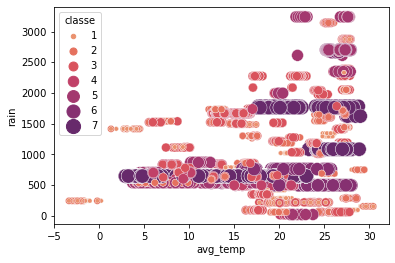

In [10]:

sns.scatterplot(
    data=data, x="avg_temp", y="rain", hue="classe", palette="flare", size="classe",
    sizes=(200, 20), legend="full"
)



<ipython-input-11-b22df1f75dfc>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=data[(data["Area"]=="France")|(data["Area"]=="Germany")|(merged['Area']=='Austria')|(merged['Area']=='Portugal')]


<AxesSubplot:xlabel='avg_temp', ylabel='pesticide_amound'>

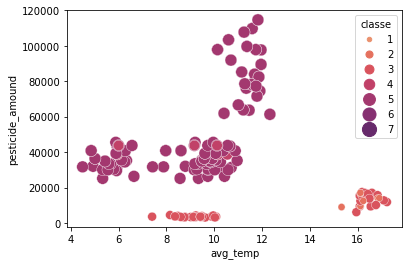

In [11]:
data=data[(data["Area"]=="France")|(data["Area"]=="Germany")|(merged['Area']=='Austria')|(merged['Area']=='Portugal')]
sns.scatterplot(
    data=data, x="avg_temp", y="pesticide_amound", hue="classe", palette="flare", size="classe",
    sizes=(200, 20), legend="full"
)

Etude plus en detail des pesticide

In [39]:
merged

,Area,Year,rain,avg_temp,Item_x,Element_x,Unit_x,yield_amound,Domain,Element_y,Item_y,Unit_y,pesticide_amound
33,Angola,1990,1010.0,24.12,Bananas,Production,tonnes,270000.00,Pesticides Use,Agricultural Use,Pesticides (total),tonnes,64.0
34,Angola,1990,1010.0,24.12,Bananas,Production,tonnes,270000.00,Pesticides Use,Agricultural Use,Insecticides,tonnes,56.0
35,Angola,1990,1010.0,24.12,Bananas,Production,tonnes,270000.00,Pesticides Use,Agricultural Use,Insecticides â Chlorinated Hydrocarbons,tonnes,30.0
36,Angola,1990,1010.0,24.12,Bananas,Production,tonnes,270000.00,Pesticides Use,Agricultural Use,Insecticides â Organo-phosphates,tonnes,17.0
37,Angola,1990,1010.0,24.12,Bananas,Production,tonnes,270000.00,Pesticides Use,Agricultural Use,Insecticides â Carbamates,tonnes,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15909234,Zimbabwe,2013,657.0,19.76,Vegetables Primary,Production,tonnes,220462.21,Pesticides Use,Agricultural Use,Insecticides â Seed Treatments,tonnes,0.0
15909235,Zimbabwe,2013,657.0,19.76,Vegetables Primary,Production,tonnes,220462.21,Pesticides Use,Agricultural Use,Plant Growth Regulators,tonnes,177.7
15909236,Zimbabwe,2013,657.0,19.76,Vegetables Primary,Production,tonnes,220462.21,Pesticides Use,Agricultural Use,Rodenticides,tonnes,0.0
15909237,Zimbabwe,2013,657.0,19.76,Vegetables Primary,Production,tonnes,220462.21,Pesticides Use,Agricultural Use,Rodenticides â Anti-coagulants,tonnes,0.0


In [40]:
print('Item_x',len(merged['Item_y'].unique()),merged['Item_y'].unique())

Item_x 47 ['Pesticides (total)' 'Insecticides'
 'Insecticides â\x80\x93 Chlorinated Hydrocarbons'
 'Insecticides â\x80\x93 Organo-phosphates'
 'Insecticides â\x80\x93 Carbamates' 'Insecticides â\x80\x93 Pyrethroids'
 'Herbicides' 'Fungicides and Bactericides' 'Fung & Bact â\x80\x93 Other'
 'Rodenticides' 'Rodenticides â\x80\x93 Anti-coagulants'
 'Fungicides â\x80\x93 Seed treatments'
 'Insecticides â\x80\x93 Seed Treatments' 'Plant Growth Regulators'
 'Other Pesticides nes' 'Mineral Oils' 'Insecticides â\x80\x93 Other'
 'Herbicides â\x80\x93 Phenoxy hormone products'
 'Herbicides â\x80\x93 Other' 'Fung & Bact â\x80\x93 Inorganics'
 'Fung & Bact â\x80\x93 Dithiocarbamates' 'Herbicides â\x80\x93 Triazines'
 'Herbicides â\x80\x93 Carbamates' 'Herbicides â\x80\x93 Dinitroanilines'
 'Herbicides â\x80\x93 Urea derivates'
 'Fung & Bact â\x80\x93 Benzimidazoles'
 'Insecticides â\x80\x93 Botanical products and biologicals'
 'Herbicides â\x80\x93 Amides' 'Herbicides â\x80\x93 Sulfonyl ureas'
 'F

In [45]:
data=merged[(merged['Item_y']=='Insecticides')|(merged['Item_y']=='Herbicides')|(merged['Item_y']=='Fungicides and Bactericides')|(merged['Item_y']=='Rodenticides')|(merged['Item_y']=='Plant Growth Regulators')|(merged['Item_y']=='Mineral Oils')|(merged['Item_y']=='Disinfectants')]

In [46]:
#creates yield classes 
# Binning:
def binning(col, cut_points, labels=None):
    # Définir les valeurs min et max:
    minval = col.min()
    maxval = col.max()

    # Créer une liste en ajoutant min et max à cut_points
    break_points = [minval] + cut_points + [maxval]

    # Si aucun label, on utilise par défaut les labels 0 ... (n-1)
    if not labels:
        labels = range(len(cut_points)+1)

    # Regroupement en utilisant la fonction cut de Pandas
    colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
    return colBin

cut_points = [200,700,1100,2000,10000,95000000]
labels = ["1","2","3","4","5","6","7"] # 1= low yield 5= very high yield 
data["classe"] = binning(data["yield_amound"], cut_points, labels)
print(pd.value_counts(data["classe"], sort=False))

1     440161
2     201007
3     101248
4     140759
5     457719
6    1468265
7       5573
Name: classe, dtype: int64


<ipython-input-46-da13683a3937>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["classe"] = binning(data["yield_amound"], cut_points, labels)


In [73]:
data

,Area,Year,rain,avg_temp,Item_x,Element_x,Unit_x,yield_amound,Domain,Element_y,Item_y,Unit_y,pesticide_amound,classe
16444,Austria,1990,1110.0,9.23,Apples,Production,tonnes,337741.00,Pesticides Use,Agricultural Use,Insecticides,tonnes,285.00,2
16445,Austria,1990,1110.0,9.23,Apples,Production,tonnes,337741.00,Pesticides Use,Agricultural Use,Mineral Oils,tonnes,292.00,2
16446,Austria,1990,1110.0,9.23,Apples,Production,tonnes,337741.00,Pesticides Use,Agricultural Use,Herbicides,tonnes,1945.00,2
16447,Austria,1990,1110.0,9.23,Apples,Production,tonnes,337741.00,Pesticides Use,Agricultural Use,Fungicides and Bactericides,tonnes,1683.00,2
16448,Austria,1990,1110.0,9.23,Apples,Production,tonnes,337741.00,Pesticides Use,Agricultural Use,Plant Growth Regulators,tonnes,40.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15859025,Portugal,2013,854.0,16.77,Vegetables Primary,Production,tonnes,1974996.58,Pesticides Use,Agricultural Use,Mineral Oils,tonnes,403.67,3
15859026,Portugal,2013,854.0,16.77,Vegetables Primary,Production,tonnes,1974996.58,Pesticides Use,Agricultural Use,Herbicides,tonnes,1611.02,3
15859034,Portugal,2013,854.0,16.77,Vegetables Primary,Production,tonnes,1974996.58,Pesticides Use,Agricultural Use,Fungicides and Bactericides,tonnes,7202.96,3
15859041,Portugal,2013,854.0,16.77,Vegetables Primary,Production,tonnes,1974996.58,Pesticides Use,Agricultural Use,Plant Growth Regulators,tonnes,0.67,3


In [ ]:
sns.scatterplot(
    data=data, x="avg_temp", y="rain", hue="classe", palette="flare", size="classe",
    sizes=(200, 20), legend="full"
)



<ipython-input-78-616da89611d8>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=data[(data["Area"]=="France")|(data["Area"]=="Germany")|(merged['Area']=='Austria')|(merged['Area']=='Portugal')]


<AxesSubplot:xlabel='avg_temp', ylabel='pesticide_amound'>

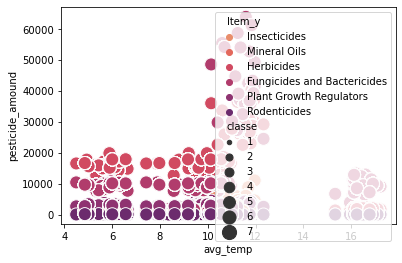

In [78]:
data=data[(data["Area"]=="France")|(data["Area"]=="Germany")|(merged['Area']=='Austria')|(merged['Area']=='Portugal')]
sns.scatterplot(
    data=data, x="avg_temp", y="pesticide_amound", hue="Item_y", palette="flare", size="classe",
    sizes=(200, 20), legend="full"
)

<ipython-input-47-c65c1a51f0d8>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_cereal=data_cereal[(data['Item_x']=='Cereals, primary')]


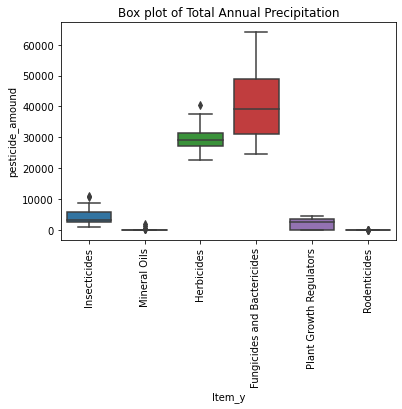

In [47]:
data_cereal=data[(data['Area']=='France')]
data_cereal=data_cereal[(data['Item_x']=='Cereals, primary')]
sns.boxplot(x="Item_y", y="pesticide_amound", data=data_cereal).set_title("Box plot of Total Annual Precipitation")
plt.xticks(rotation=90)
plt.show()

<ipython-input-69-f1682327ef35>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_cereal=data_cereal[(data['Item_x']=='Cereals, primary')]


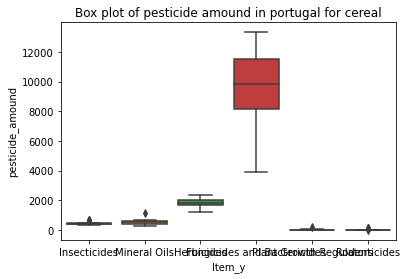

In [69]:
data_cereal=data[(data['Area']=='Portugal')]
data_cereal=data_cereal[(data['Item_x']=='Cereals, primary')]
sns.boxplot(x="Item_y", y="pesticide_amound", data=data_cereal).set_title("Box plot of pesticide amound in portugal for cereal")
plt.show()

<ipython-input-68-9f3b2c8f90b8>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_cereal=data_cereal[(data['Item_x']=='Rice')]


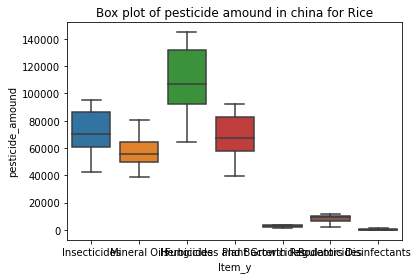

In [68]:
data_cereal=data[(data['Area']=='China')]
data_cereal=data_cereal[(data['Item_x']=='Rice')]
sns.boxplot(x="Item_y", y="pesticide_amound", data=data_cereal).set_title("Box plot of pesticide amound in china for Rice")
plt.show()

,yield_amound,pesticide_amound
Item_y,,
Disinfectants,1.748164e+07,474.837265
Fungicides and Bactericides,8.184622e+06,24009.271257
Herbicides,8.187027e+06,39778.236892
Insecticides,8.139089e+06,26820.982001
Mineral Oils,1.126208e+07,33679.726739
Plant Growth Regulators,9.438033e+06,1114.873551
Rodenticides,8.890231e+06,2625.108479


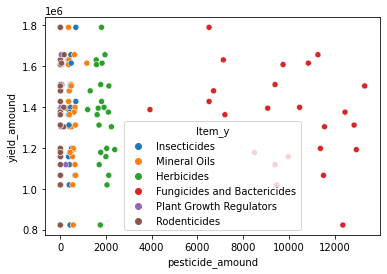

In [64]:
sns.scatterplot(
    data=data_cereal, x="pesticide_amound", y="yield_amound", hue="Item_y"
)
A=data.groupby("Item_y")[["yield_amound","pesticide_amound"]].mean()
A

### Two way anova 

In [ ]:
anova_variete <- lm(rdt~variete,data=ble)
summary(anova_variete)

In [46]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('yield_amound ~ Area', data=merged).fit()
sm.stats.anova_lm(model, typ=2)